This notebook serves to update the figures in the paper

In [1]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
import matplotlib as mpl
font = {'size'   : 26}
mpl.rc('font', **font)

import numpy as np
from astropy.cosmology import Planck18, z_at_value
cosmo = Planck18
from scipy import integrate
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pickle, os

import h5py
import astropy.units as u

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    

    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic in intcum:
            CIz = []
            for lim in lims:
                CIz.append(x[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)


In [3]:
cosmo = Planck18# Define temporary cosmology for volume calculation
tot_sky = 41253. # Total square degrees in the sky

halo_model = "SMT"

mmin = 3 # Minimum halo mass for HMF
mmax = 15 # Maximum halo mass for HMF

baryon_frac = 0.16 # from Planck18
c = 'orange'

Now let's make the distribution of masses given some number of sampled overdensities

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

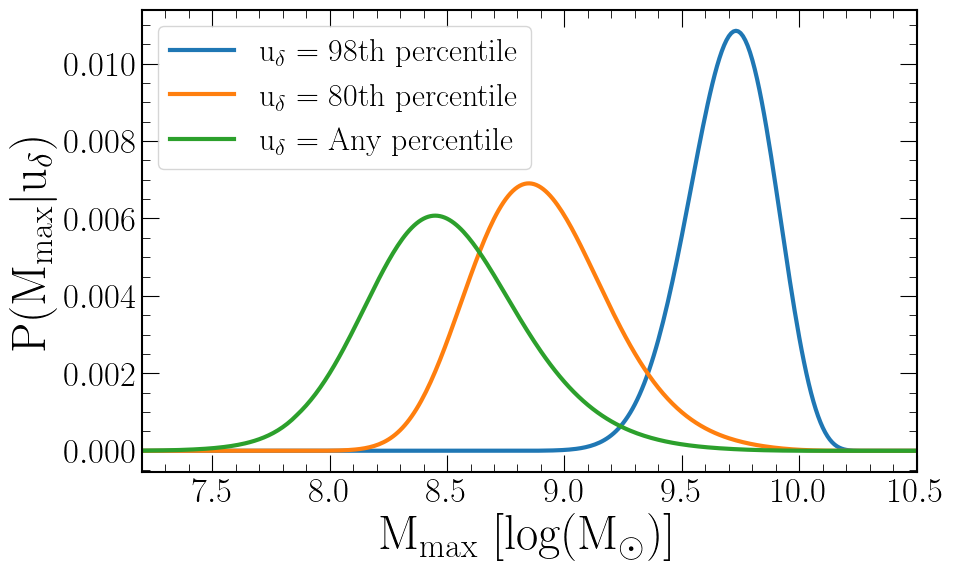

In [4]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['98th', '80th', 'Any']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]

    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], lw = lw, label = r'$\mathrm{u}_{\delta}$'+' = '+sigl + ' percentile')
ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{u}_{\delta})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
ax.legend()
fig
# fig.savefig('paper/demo_dists.png', dpi = 200, bbox_inches = 'tight')

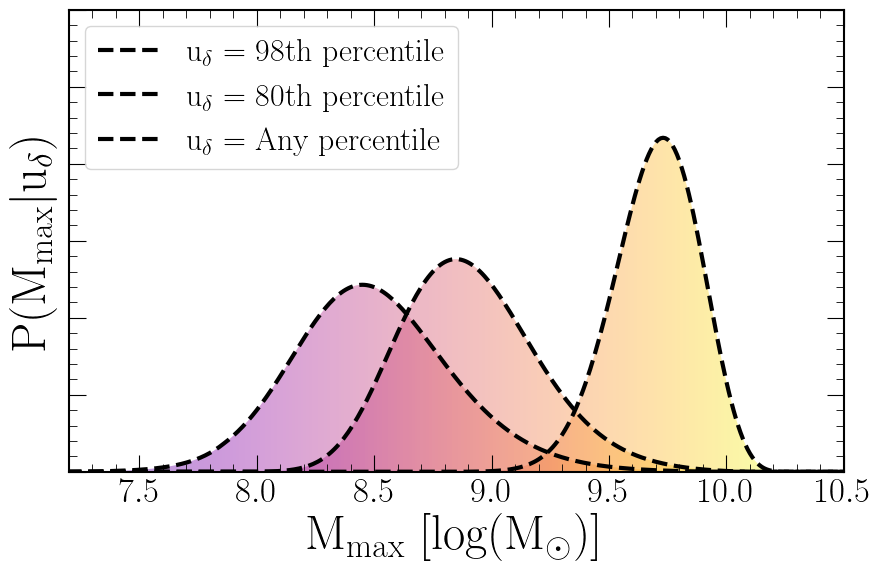

In [25]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['98th', '80th', 'Any']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]
        
    ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{u}_{\delta})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], 'k', linestyle = 'dashed', lw = lw, label = r'$\mathrm{u}_{\delta}$'+' = '+sigl + ' percentile')
    polygon = ax.fill_between(log10m[:-1][::2][0:320], 0, phi_max_conv[10][::2][0:320], lw=0, color='none')
    verts = np.vstack([p.vertices for p in polygon.get_paths()])
    gradient = ax.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap='plasma', aspect='auto',
                          extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()], alpha = 0.4)
    gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)


ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{u}_{\delta})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$',\
       ylim = (0, 0.015), yticklabels = [])
ax.legend()

fig

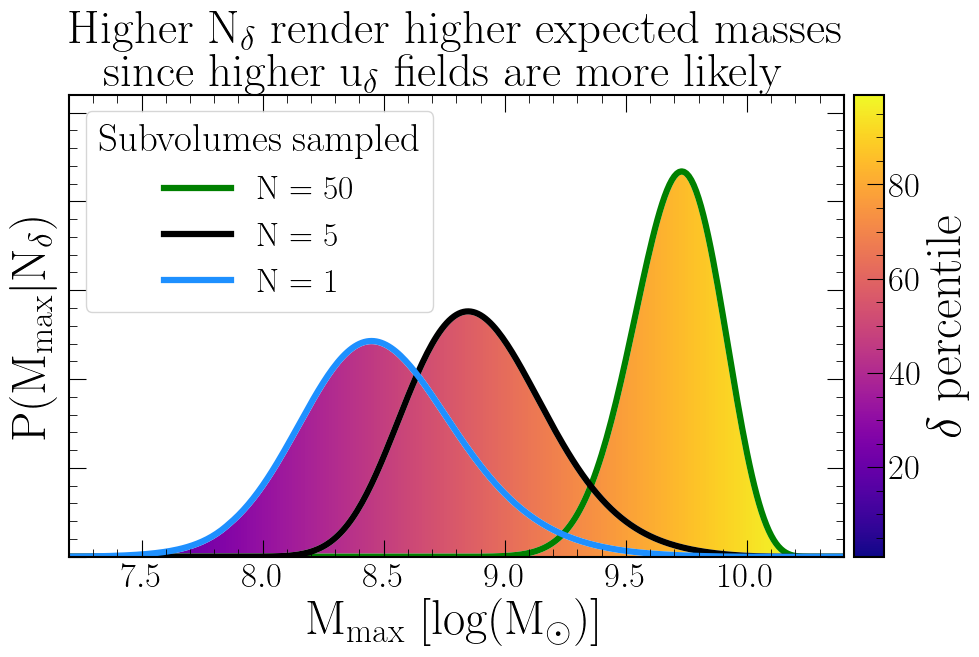

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import cm, colors

lw = 4.5
lw_white = 1
fig, ax = plt.subplots(figsize=(10, 6))

sigs = [-1.2, -3.3, -10]
sig_labels = ['98th', '80th', 'Any']
sig_labels = ['50', '5', '1']

all_x = []
all_y = []
# colors_lines = ['g', 'k', 'silver']
colors_lines = ['g', 'k', 'dodgerblue']

i = 0
# Plot each curve and collect the points for envelope
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5', 'r') as hf:
        log10m = hf['log10m'][:]
        phi_max_conv = hf['phi_max_conv'][:]

    x = log10m[:-1][::2]
    y = phi_max_conv[10][::2]

    all_x.append(x)
    all_y.append(y)
    
    ax.plot(x, y, color = colors_lines[i], linestyle = '-', lw=lw,  label = r'$\mathrm{N}$'+' = '+sigl, zorder = 1)
    ax.plot(x, y, color = 'white', linestyle = '-', lw=lw*lw_white, zorder = -1)
    
    i+=1
# Make unified fill up to the maximum value across all curves
x_common = all_x[0][0:320]
y_max = np.maximum.reduce(all_y)[0:320]

# Plot the gradient once under the envelope
polygon = ax.fill_between(x_common, 0, y_max, lw=0, color='none')
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = ax.imshow(
    np.linspace(0, 1, 256).reshape(1, -1),
    cmap='plasma',
    aspect='auto',
    extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()],
    alpha=1, 
    zorder = -3
)
gradient.set_clip_path(polygon.get_paths()[0], transform=ax.transData)

# Final touches
ax.set(
    xlim=(7.2, 10.4), 
    ylim=(0, 0.013), 
    xlabel=r'$\mathrm{M_{max}~[log(M_{\odot})]}$', 
    ylabel=r'$\mathrm{P(M_{max}|\mathrm{N}_{\delta})}$',
    yticklabels=[]
)
ax.set_title(r'Higher $\mathrm{N_{\delta}}$ render higher expected masses\\  $~~~~$   since higher $\mathrm{u_{\delta}}$ fields are more likely', fontsize = 34)

legend = ax.legend(title = "Subvolumes sampled", title_fontsize = 28, fontsize = 24, fancybox = 1)

norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
cmap = mpl.colormaps['plasma']

idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)

fig

1000
[3, 20, 100, 250, 500, 750, 960, 998]


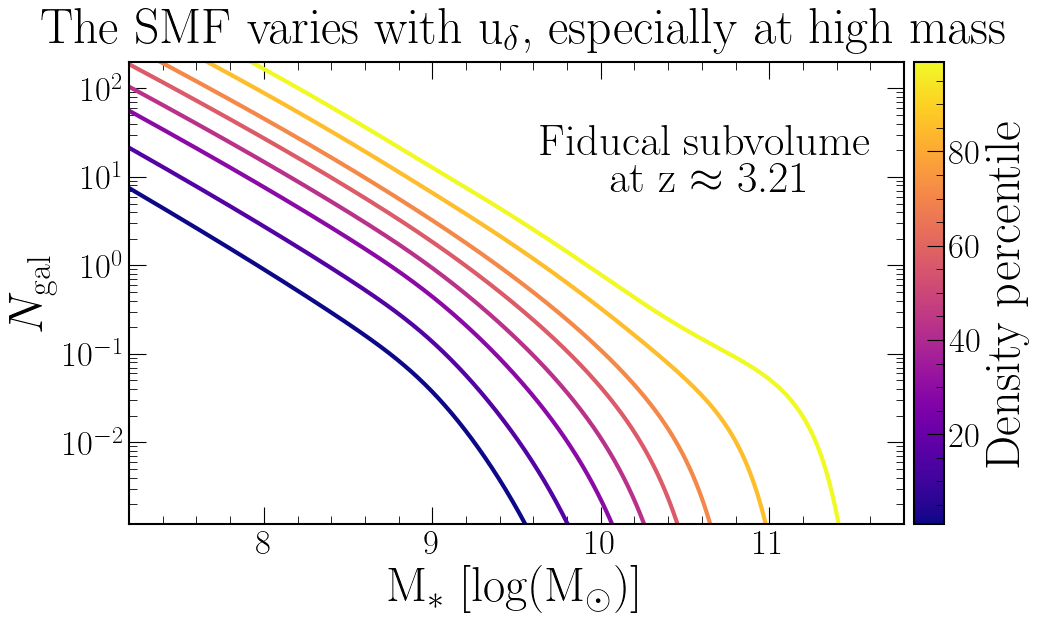

In [195]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
from scipy.ndimage import gaussian_filter1d, gaussian_filter

lw = 3
fig, ax = plt.subplots(figsize = (10,6))

sig = -0.1
with h5py.File(f'../evstats/data/test_OD_fast_{sig}.h5','r') as hf:
    log10m = hf['log10m'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
    smfs = hf['smf'][:]

norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
nsamp = 50
zidx = 0
smf = smfs[zidx]
print(len(smf.T))
# idxs = [10, 40, 250]+list(np.arange(len(smfs[10]))[nsamp-10::nsamp])+[9990]
idxs = list(np.arange(len(smf.T))[nsamp-2::nsamp])
idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
idxs = [0, 92, 173, 335, 497, 659, 821, 1095]
idxs = [9500, 9600, 9700, 9800, 9900]

idxs = [3, 20, 100, 250, 500, 750, 960, 998]


print(idxs)
lw = 3
f = 1
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
k = 0
for c, idx in zip(colors, idxs):
    ax.plot(log10m[:-1], gaussian_filter(smf.T[idx], sigma = 10)*f, \
            c = c, lw = lw, alpha = 1)
    k+=1
ax.set(xlim = (7.2, 11.8), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
       xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$', ylim = (12e-4, 2e2))
ax.set_title(r'The SMF varies with $\mathrm{u_{\delta}}$, especially at high mass', fontsize = 36, y = 1.02, x = 0.51)

# ax.set(xlim = (7.2, 10.8), ylim = (1e-3, 2.*f), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
    #    xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$')

ax.annotate(r'Fiducal subvolume', (0.53, 0.8), xycoords = 'axes fraction', fontsize = 32)
ax.annotate(r'at z $\approx$ 3.21', (0.62, 0.72), xycoords = 'axes fraction', fontsize = 32)

# Add a colorbar without shrinking the main plot
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{Density~percentile}$', pad = 0.01, cax = cbar_ax)
fig.savefig('paper/overdensity_sampled_percentile2.png', dpi = 200, bbox_inches = 'tight')
fig

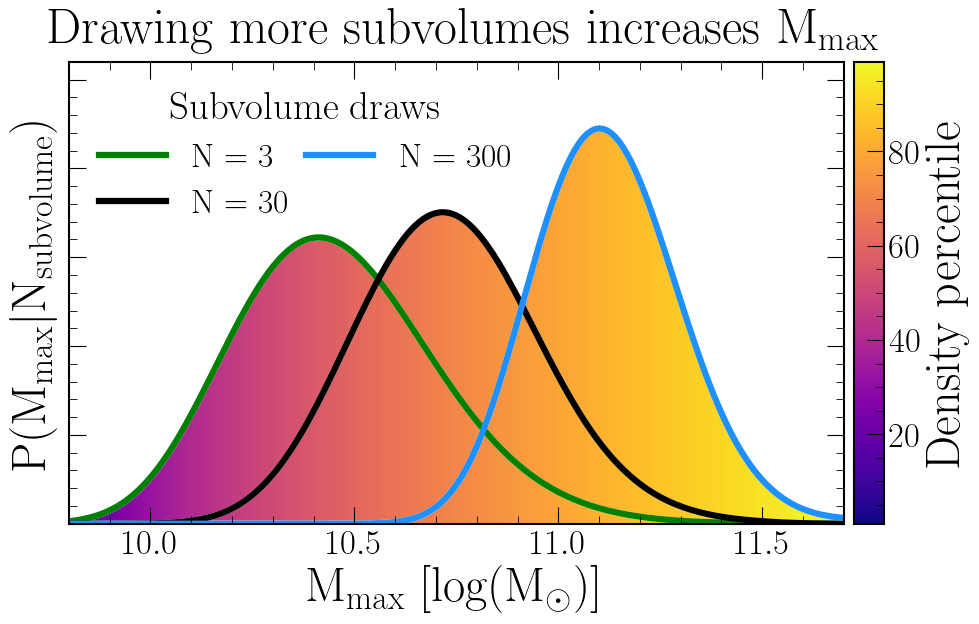

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import cm, colors

lw = 4.5
lw_white = 1
fig, ax = plt.subplots(figsize=(10, 6))

sigs = [-2, -1, 0.1]
sig_labels = ['3', '30', '300']

all_x = []
all_y = []
# colors_lines = ['g', 'k', 'silver']
colors_lines = ['g', 'k', 'dodgerblue']

i = 0
# Plot each curve and collect the points for envelope
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/test_OD_fast_{sig}.h5', 'r') as hf:
        log10m = hf['log10m'][:]
        phi_max_conv = hf['phi_max_conv'][:]
        phi_max_conv = phi_max_conv
        phi_maxs = hf['phi_maxs'][:]
        
    x = log10m[:-1][::2]
    y = phi_max_conv[0][::2]

    all_x.append(x)
    all_y.append(y)
    
    ax.plot(x, y, color = colors_lines[i], linestyle = '-', lw=lw,  label = r'$\mathrm{N}$'+' = '+sigl, zorder = 1)
    ax.plot(x, y, color = 'white', linestyle = '-', lw=lw*lw_white, zorder = -1)
    
    i+=1
# Make unified fill up to the maximum value across all curves
x_common = all_x[0][280:470]

y_max = np.maximum.reduce(all_y)[280:470]

with h5py.File(f'../evstats/data/test_OD_fast_{-2}.h5', 'r') as hf:
    log10m = hf['log10m'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]

pos_evs_OD = log10m[np.argmax( phi_maxs[0], axis = 0)]

x_positions = pos_evs_OD  # or a custom np.array of increasing x positions
normed = (x_positions - x_positions.min()) / (x_positions.max() - x_positions.min())

# Plot the gradient once under the envelope
polygon = ax.fill_between(x_common, 0, y_max, lw=0, color='none')
verts = np.vstack([p.vertices for p in polygon.get_paths()])

# # Generate the gradient colors at these positions
# cmap = plt.get_cmap('plasma')
# colors_interp = cmap(normed)

# # Create an image of shape (1, len(x_positions)) with those colors
# gradient_array = colors_interp[np.newaxis, :, :]

# # Plot the custom gradient using imshow
# gradient = ax.imshow(
#     gradient_array,
#     extent=[x_positions.min(), x_positions.max(), 0, y_max.max()],
#     aspect='auto',
#     zorder=-3
# )

gradient = ax.imshow(
    (np.linspace(0, 1, 256)**0.5).reshape(1, -1),
    cmap='plasma',
    aspect='auto',
    extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()],
    alpha=1, 
    zorder = -3
)
gradient.set_clip_path(polygon.get_paths()[0], transform=ax.transData)

# Final touches
ax.set(
    xlim=(9.8, 11.7), 
    ylim=(0, 0.013), 
    xlabel=r'$\mathrm{M_{max}~[log(M_{\odot})]}$', 
    ylabel=r'$\mathrm{P(M_{max}|\mathrm{N}_{subvolume})}$',
    yticklabels=[]
)
ax.set_title(r'Drawing more subvolumes increases $\mathrm{M_{max}}$', fontsize = 36, y = 1.02, x = 0.51)

legend = ax.legend(title = "Subvolume draws", title_fontsize = 28, fontsize = 24, fancybox = 1, ncols = 2, columnspacing = 0.5, framealpha=0)

norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
cmap = mpl.colormaps['plasma']

idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{Density~percentile}$', pad = 0.01, cax = cbar_ax)
fig.savefig('paper/increasing_Nsubvol2.png', dpi = 200, bbox_inches = 'tight')

fig

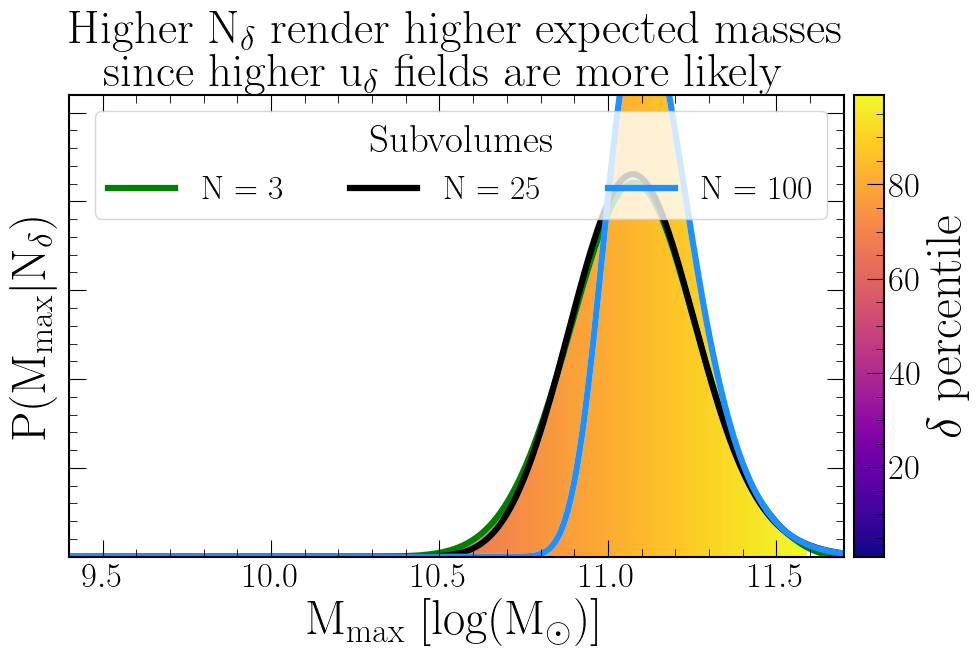

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import cm, colors

lw = 4.5
lw_white = 1
fig, ax = plt.subplots(figsize=(10, 6))

sigs = [0, 1, 2]
sig_labels = ['3', '25', '100']

all_x = []
all_y = []
# colors_lines = ['g', 'k', 'silver']
colors_lines = ['g', 'k', 'dodgerblue']

i = 0
# Plot each curve and collect the points for envelope
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/testvol{sig}_OD_fast_{0}.h5', 'r') as hf:
        log10m = hf['log10m'][:]
        phi_max_conv = hf['phi_max_conv'][:]
        phi_max_conv = phi_max_conv
        phi_maxs = hf['phi_maxs'][:]
        
    x = log10m[:-1][::2]
    y = phi_max_conv[0][::2]

    all_x.append(x)
    all_y.append(y)
    
    ax.plot(x, y, color = colors_lines[i], linestyle = '-', lw=lw,  label = r'$\mathrm{N}$'+' = '+sigl, zorder = 1)
    ax.plot(x, y, color = 'white', linestyle = '-', lw=lw*lw_white, zorder = -1)
    
    i+=1
# Make unified fill up to the maximum value across all curves
x_common = all_x[0][200:460]

y_max = np.maximum.reduce(all_y)[200:460]

with h5py.File(f'../evstats/data/test_OD_fast_{-2}.h5', 'r') as hf:
    log10m = hf['log10m'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]

pos_evs_OD = log10m[np.argmax( phi_maxs[0], axis = 0)]

x_positions = pos_evs_OD  # or a custom np.array of increasing x positions
normed = (x_positions - x_positions.min()) / (x_positions.max() - x_positions.min())

# Plot the gradient once under the envelope
polygon = ax.fill_between(x_common, 0, y_max, lw=0, color='none')
verts = np.vstack([p.vertices for p in polygon.get_paths()])

# # Generate the gradient colors at these positions
# cmap = plt.get_cmap('plasma')
# colors_interp = cmap(normed)

# # Create an image of shape (1, len(x_positions)) with those colors
# gradient_array = colors_interp[np.newaxis, :, :]

# # Plot the custom gradient using imshow
# gradient = ax.imshow(
#     gradient_array,
#     extent=[x_positions.min(), x_positions.max(), 0, y_max.max()],
#     aspect='auto',
#     zorder=-3
# )

gradient = ax.imshow(
    (np.linspace(0.1, 1, 256)**0.7).reshape(1, -1),
    cmap='plasma',
    aspect='auto',
    extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()],
    alpha=1, 
    zorder = -3
)
gradient.set_clip_path(polygon.get_paths()[0], transform=ax.transData)

# Final touches
ax.set(
    xlim=(9.4, 11.7), 
    ylim=(0, 0.013), 
    xlabel=r'$\mathrm{M_{max}~[log(M_{\odot})]}$', 
    ylabel=r'$\mathrm{P(M_{max}|\mathrm{N}_{\delta})}$',
    yticklabels=[]
)
ax.set_title(r'Higher $\mathrm{N_{\delta}}$ render higher expected masses\\  $~~~~$   since higher $\mathrm{u_{\delta}}$ fields are more likely', fontsize = 34)

legend = ax.legend(title = "Subvolumes", title_fontsize = 28, fontsize = 24, fancybox = 1, ncols = 3)

norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
cmap = mpl.colormaps['plasma']

idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)

fig

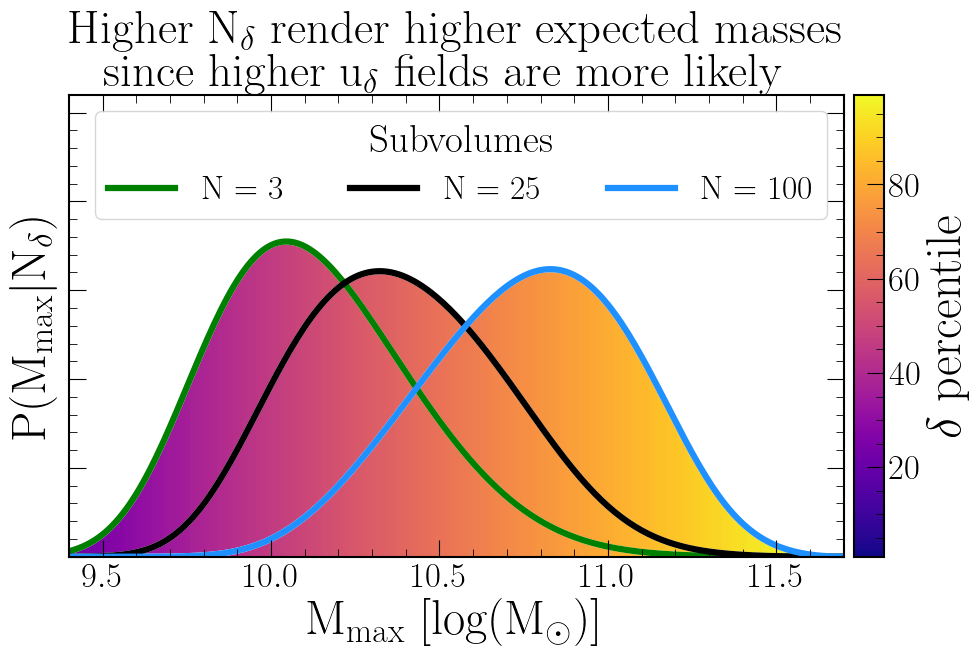

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import cm, colors

lw = 4.5
lw_white = 1
fig, ax = plt.subplots(figsize=(10, 6))

sigs = [-2, -1, 0.1]
sig_labels = ['3', '25', '100']

all_x = []
all_y = []
# colors_lines = ['g', 'k', 'silver']
colors_lines = ['g', 'k', 'dodgerblue']

i = 0
# Plot each curve and collect the points for envelope
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/test_OD_fast_{sig}.h5', 'r') as hf:
        log10m = hf['log10m'][:]
        phi_max_conv = hf['phi_max_conv'][:]
        phi_max_conv = phi_max_conv/150
        phi_maxs = hf['phi_maxs'][:]
        
    x = log10m[:-1][::2]
    y = phi_max_conv[0][::2]

    all_x.append(x)
    all_y.append(y)
    
    ax.plot(x, y, color = colors_lines[i], linestyle = '-', lw=lw,  label = r'$\mathrm{N}$'+' = '+sigl, zorder = 1)
    ax.plot(x, y, color = 'white', linestyle = '-', lw=lw*lw_white, zorder = -1)
    
    i+=1
# Make unified fill up to the maximum value across all curves
x_common = all_x[0][200:460]

y_max = np.maximum.reduce(all_y)[200:460]

with h5py.File(f'../evstats/data/test_OD_fast_{-2}.h5', 'r') as hf:
    log10m = hf['log10m'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]

pos_evs_OD = log10m[np.argmax( phi_maxs[0], axis = 0)]

x_positions = pos_evs_OD  # or a custom np.array of increasing x positions
normed = (x_positions - x_positions.min()) / (x_positions.max() - x_positions.min())

# Plot the gradient once under the envelope
polygon = ax.fill_between(x_common, 0, y_max, lw=0, color='none')
verts = np.vstack([p.vertices for p in polygon.get_paths()])

# # Generate the gradient colors at these positions
# cmap = plt.get_cmap('plasma')
# colors_interp = cmap(normed)

# # Create an image of shape (1, len(x_positions)) with those colors
# gradient_array = colors_interp[np.newaxis, :, :]

# # Plot the custom gradient using imshow
# gradient = ax.imshow(
#     gradient_array,
#     extent=[x_positions.min(), x_positions.max(), 0, y_max.max()],
#     aspect='auto',
#     zorder=-3
# )

gradient = ax.imshow(
    (np.linspace(0.1, 1, 256)**0.7).reshape(1, -1),
    cmap='plasma',
    aspect='auto',
    extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()],
    alpha=1, 
    zorder = -3
)
gradient.set_clip_path(polygon.get_paths()[0], transform=ax.transData)

# Final touches
ax.set(
    xlim=(9.4, 11.7), 
    ylim=(0, 0.013), 
    xlabel=r'$\mathrm{M_{max}~[log(M_{\odot})]}$', 
    ylabel=r'$\mathrm{P(M_{max}|\mathrm{N}_{\delta})}$',
    yticklabels=[]
)
ax.set_title(r'Higher $\mathrm{N_{\delta}}$ render higher expected masses\\  $~~~~$   since higher $\mathrm{u_{\delta}}$ fields are more likely', fontsize = 34)

legend = ax.legend(title = "Subvolumes", title_fontsize = 28, fontsize = 24, fancybox = 1, ncols = 3)

norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
cmap = mpl.colormaps['plasma']

idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)

fig

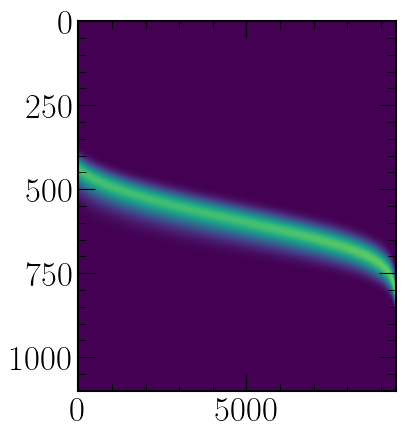

In [78]:
with h5py.File(f'../evstats/data/test_OD_fast_{-2}.h5', 'r') as hf:
    log10m = hf['log10m'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]
phi_maxs[0].shape
fig = plt.figure()
plt.imshow(phi_maxs[0], aspect = 10)
fig

In [ ]:
log10m[np.argmax( phi_maxs[0], axis = 0)]

array([ 9.195,  9.195,  9.195, ..., 11.295, 11.345, 11.445])

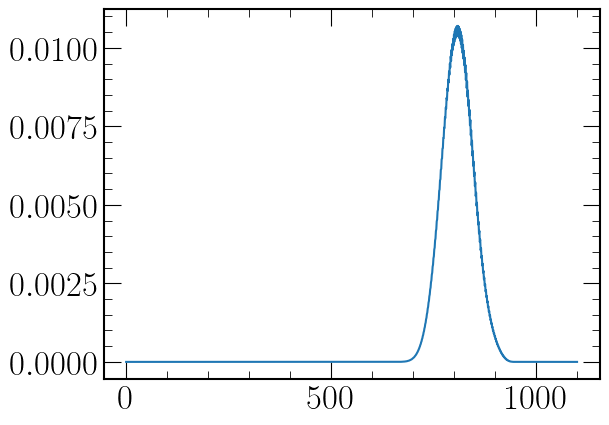

In [ ]:
fig = plt.figure()
plt.plot(phi_max_conv[0])
fig

[5, 92, 173, 335, 497, 659, 821, 902, 980]


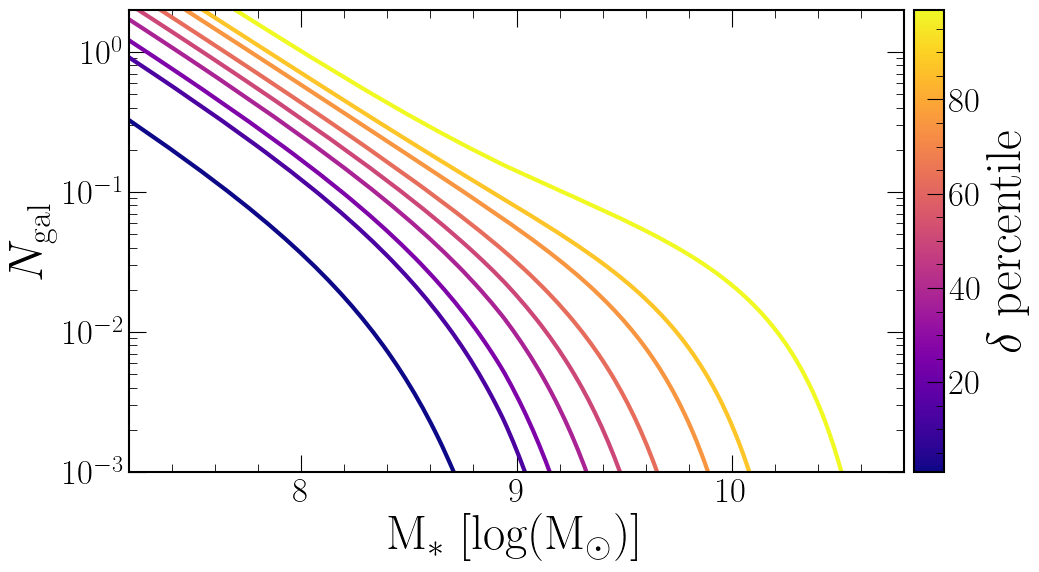

In [162]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
fig, ax = plt.subplots(figsize = (10,6))
nsamp = 81
zidx = 0
smf = smfs[zidx]
# idxs = [10, 40, 250]+list(np.arange(len(smfs[10]))[nsamp-10::nsamp])+[9990]
idxs = list(np.arange(len(smf.T))[nsamp-70::nsamp])
idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
print(idxs)
lw = 3
f = 1
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
k = 0
for c, idx in zip(colors, idxs):
    ax.plot(log10m[:-1], gaussian_filter(smf.T[idx], sigma = 1)*f, \
            c = c, lw = lw, alpha = 1)
    k+=1
ax.set(xlim = (7.2, 10.8), ylim = (1e-3, 2.*f), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
       xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$')

# Add a colorbar without shrinking the main plot
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)
fig
# fig.savefig('paper/overdensity_sampled_percentile.png', dpi = 200, bbox_inches = 'tight')

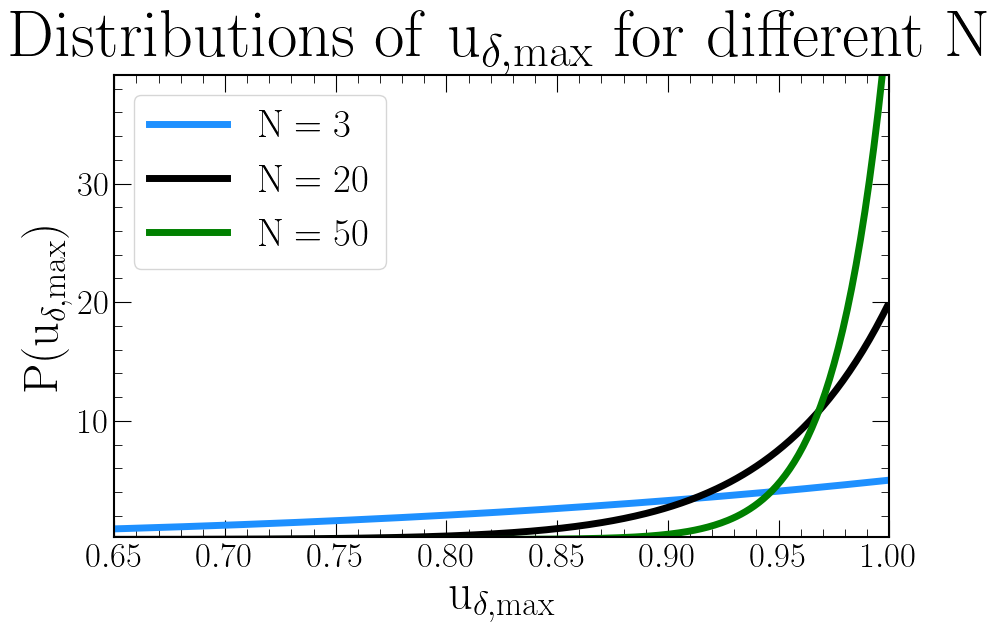

In [144]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 6))

c1 = 'k'
c2 = 'r'
lwd = 5

l = 1e-5
fs = 35

nsamp = 1e3
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
N = 5
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs0 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], colors_lines[2], linewidth = lwd, label = r'$\mathrm{N=3}$')

N = 20
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs1 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], colors_lines[1], linewidth = lwd, label = r'$\mathrm{N=20}$')

N = 45
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], colors_lines[0], linewidth = lwd, label = r'$\mathrm{N=50}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'linear', ylim = (2e-1, max(evs2)/1.1), xlim = (0.65,1), xlabel = r'$\mathrm{ u_{\delta,max}}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Distributions~of~u_{\delta,\mathrm{max}}~for~different~N}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig


python(17787) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17792) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17854) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17887) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17895) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17898) Malloc

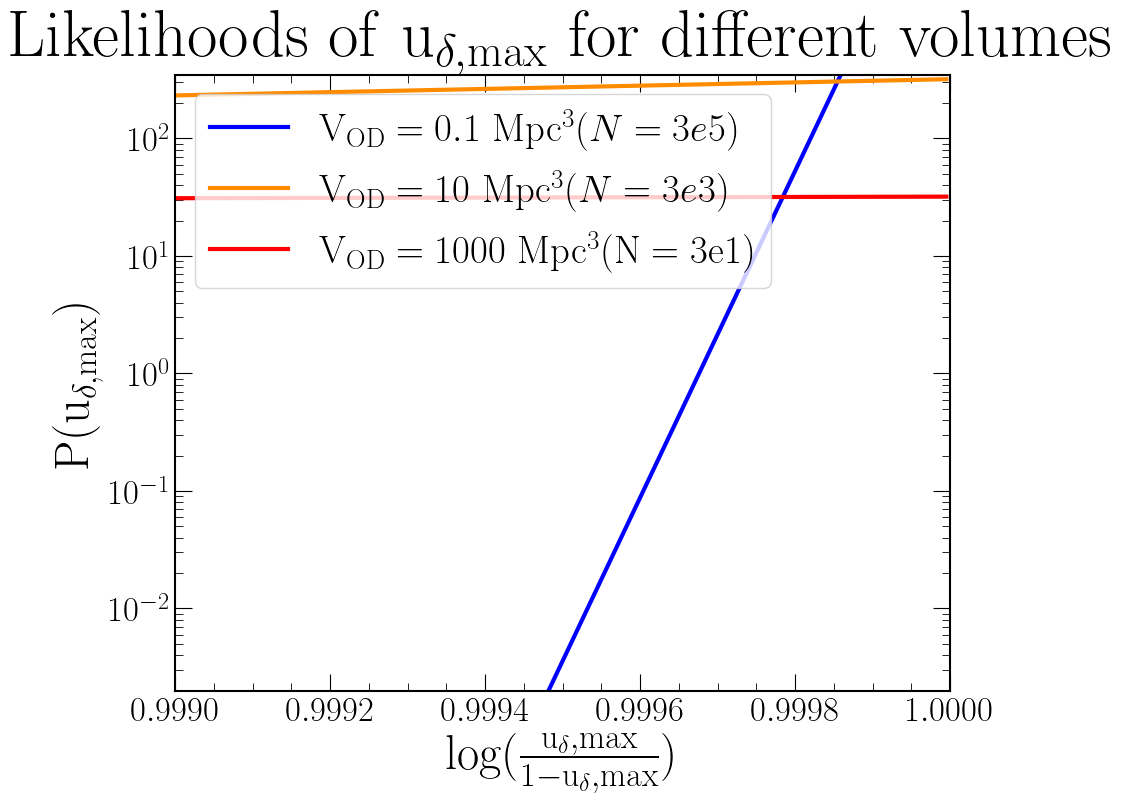

In [61]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-5
fs = 35

N = 3.2*1e5
nsamp = 2e5
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))

N *= 1/10
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

evs0 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V_{OD}=0.1~Mpc^3} (N = 3e5)$')

N *= 1/100
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

evs1 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V_{OD}=10~Mpc^3} (N = 3e3)$')

N *= 1/10
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V_{OD}=1000~Mpc^3 (N = 3e1)}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'log', ylim = (2e-3, 3.5e2), xlim = (0.999, 1), xlabel = r'$\mathrm{log(\frac{ u_{\delta}, max}{1-u_{\delta}, max})}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig


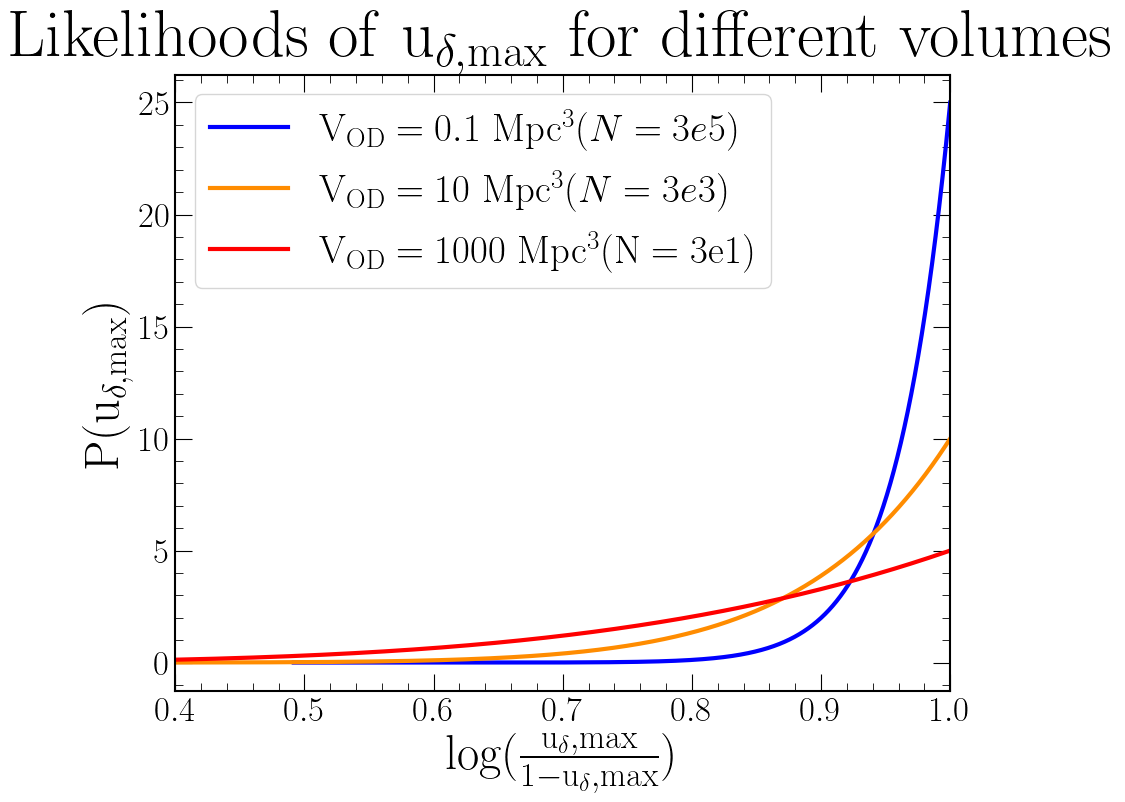

In [71]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-6
fs = 35

N = 25
nsamp = 2e5
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs0 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V_{OD}=0.1~Mpc^3} (N = 3e5)$')

N = 10
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

evs1 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V_{OD}=10~Mpc^3} (N = 3e3)$')

N = 5
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V_{OD}=1000~Mpc^3 (N = 3e1)}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'linear', xlim = (0.4, 1), xlabel = r'$\mathrm{log(\frac{ u_{\delta}, max}{1-u_{\delta}, max})}$',\
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig


In [36]:
stacked = np.vstack([x, evs0, evs1, evs2])
np.save('EVS_uniform.npy', stacked)

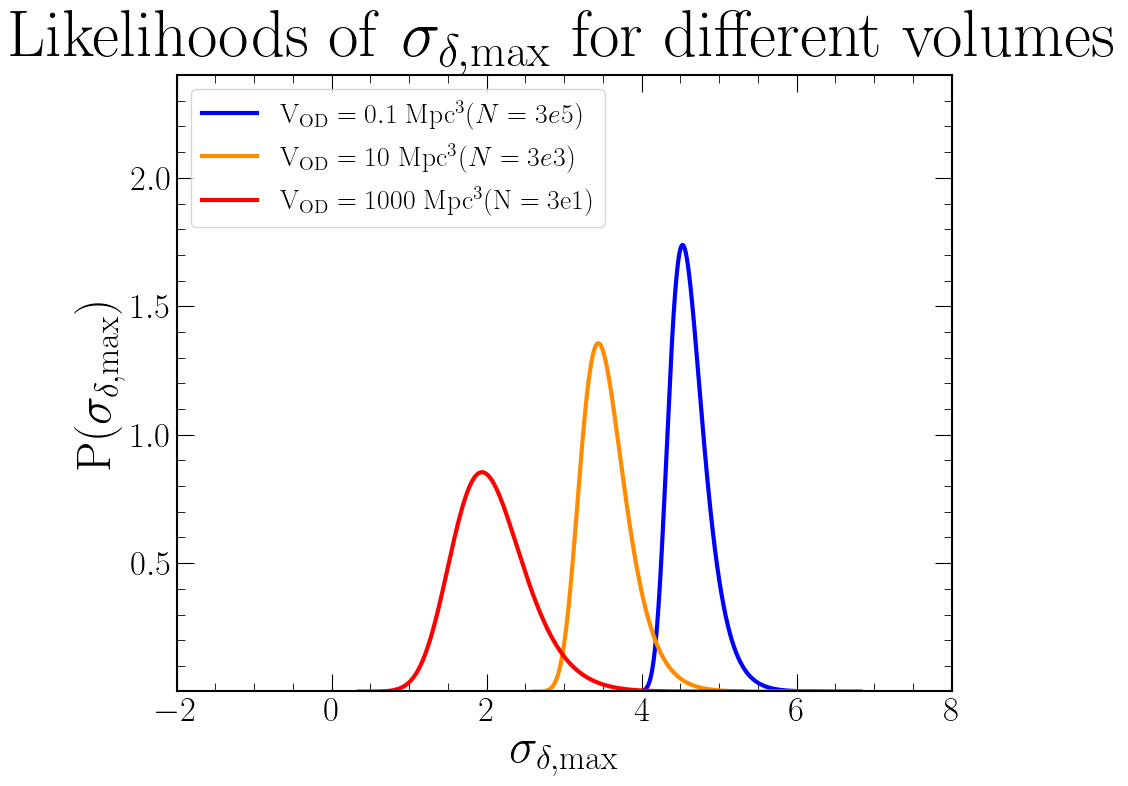

In [47]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
cmed = 'darkorange' 
csmall = 'red' 

l = 1e-5
fs = 35

N = 3.2*1e5
nsamp = 2e5
# x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
x = np.linspace(-10, 10, int(nsamp))


evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)

evs0 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V_{OD}=0.1~Mpc^3} (N = 3e5)$')

N *= 1/100
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)

evs1 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], cmed, linewidth = 3, label = r'$\mathrm{V_{OD}=10~Mpc^3} (N = 3e3)$')

N *= 1/100
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
evs2 = np.copy(evs)
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V_{OD}=1000~Mpc^3 (N = 3e1)}$')

#r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$'
ax.set(yscale = 'linear', ylim = (2e-3, 2.4), xlim = (-2, 8), xlabel = r'$\mathrm{\sigma_{\delta,\mathrm{max}}}$',\
       ylabel = r'$\mathrm{P(\sigma_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~\sigma_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 20, columnspacing = 0.8)
fig
